In [3]:
from pathlib import Path
from kedro.framework.startup import configure_project
from kedro.framework.session import KedroSession

# Remplace par le nom de ton package (si c’est "edf_energy_forecast", garde ça)
project_path = Path("../").resolve()
configure_project("edf_energy_forecast")

session = KedroSession.create(project_path)
context = session.load_context()
catalog = context.catalog

df_corrige = catalog.load("df_corrige")
df_corrige.head()

[05/11/25 22:07:37] INFO     Using                                                                  ]8;id=563658;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro\framework\project\__init__.py\__init__.py]8;;\:]8;id=329572;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro\framework\project\__init__.py#270\270]8;;\
                             'C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro\f                
                             ramework\project\rich_logging.yml' as logging configuration.                          

[05/11/25 22:07:38] WARNING  C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro\io ]8;id=506415;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=686571;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             \data_catalog.py:165: KedroDeprecationWarning: `DataCatalog` has been                 
                             deprecated and will be replaced by `KedroDataCatalog`, in Kedro                       
                             1.0.0.Currently some `KedroDataCatalog` APIs have been retained for                   
                             compatibility with `DataCatalog`, including the `datasets` property                   
                             and the `get_datasets`, `_get_datasets`, `add`,` list`,                               
                             `add_feed_dict`, and `shallow_copy` methods. These will be removed or                 
                             replaced with updated alternatives in Kedro 1.0.0. For more details,                  
                             refer to the documentation:                                                           
                             https://docs.kedro.org/en/stable/data/index.html#kedrodatacatalog-expe                
                             rimental-feature                                                                      
                               warnings.warn(                                                                      
                                                                                                                   

[05/11/25 22:07:39] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=624772;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro_telemetry\plugin.py\plugin.py]8;;\:]8;id=336209;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro_telemetry\plugin.py#233\233]8;;\
                             the product. No personal data or IP addresses are stored on our side. If              
                             you want to opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK`              
                             environment variables, or create a `.telemetry` file in the current                   
                             working directory with the contents `consent: false`. Read more at                    
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

[05/11/25 22:07:40] INFO     Loading data from df_corrige (CSVDataSet)...                       ]8;id=790143;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=626632;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro\io\data_catalog.py#401\401]8;;\

,Type de jour TEMPO,Date,Heures,Prévision J,Prévision J-1,Consommation,Jour,Weekend,Saison
0,BLEU,2014-09-01,00:00,42500.0,42600.0,43320.0,Lundi,0,Automne
1,BLEU,2014-09-01,00:30,40300.0,40300.0,41174.0,Lundi,0,Automne
2,BLEU,2014-09-01,01:00,38000.0,37800.0,38430.0,Lundi,0,Automne
3,BLEU,2014-09-01,01:30,38300.0,37800.0,37800.0,Lundi,0,Automne
4,BLEU,2014-09-01,02:00,37400.0,37400.0,37137.0,Lundi,0,Automne


In [4]:
from pathlib import Path
from kedro.framework.startup import configure_project
from kedro.framework.session import KedroSession
import mlflow
import mlflow.prophet
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

[05/11/25 22:07:44] WARNING  C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\tqdm\aut ]8;id=621751;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=930538;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             o.py:21: TqdmWarning: IProgress not found. Please update jupyter and                  
                             ipywidgets. See                                                                       
                             https://ipywidgets.readthedocs.io/en/stable/user_install.html                         
                               from .autonotebook import tqdm as notebook_tqdm                                     
                                                                                                                   

[05/11/25 22:07:46] ERROR    Importing plotly failed. Interactive plots will not work.                   ]8;id=324849;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\prophet\plot.py\plot.py]8;;\:]8;id=834354;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\prophet\plot.py#39\39]8;;\

In [11]:
# 2. Préparer les données pour Prophet
df_prophet = df_corrige.copy()
df_prophet["ds"] = pd.to_datetime(df_prophet["Date"] + " " + df_prophet["Heures"])
df_prophet["y"] = df_prophet["Consommation"]
df_prophet = df_prophet.sort_values("ds")

# 3. Séparer en train/test (80/20)
split_point = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:split_point]
test_df = df_prophet.iloc[split_point:]

In [13]:
# 4. Lancer un run MLflow
with mlflow.start_run():
    model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    model.fit(train_df[["ds", "y"]])
    
    future = test_df[["ds"]]
    forecast = model.predict(future)
    
    y_true = test_df["y"].values
    y_pred = forecast["yhat"].values

    # Calcul des métriques
    rmse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

[05/11/25 20:35:53] DEBUG    cmd: where.exe tbb.dll                                                   ]8;id=926275;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\utils\command.py\command.py]8;;\:]8;id=535355;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\utils\command.py#37\37]8;;\
                             cwd: None                                                                             

                    DEBUG    TBB already found in load path                                            ]8;id=753213;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py\model.py]8;;\:]8;id=156841;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py#254\254]8;;\

[05/11/25 20:35:55] DEBUG    input tempfile:                                                      ]8;id=821709;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\utils\filesystem.py\filesystem.py]8;;\:]8;id=480972;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\utils\filesystem.py#118\118]8;;\
                             C:\Users\boudj\AppData\Local\Temp\tmp7xluzght\tmh9hhs0.json                           

[05/11/25 20:36:27] DEBUG    input tempfile:                                                      ]8;id=320902;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\utils\filesystem.py\filesystem.py]8;;\:]8;id=513853;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\utils\filesystem.py#118\118]8;;\
                             C:\Users\boudj\AppData\Local\Temp\tmp7xluzght\3pmpm7d6.json                           

                    DEBUG    idx 0                                                                    ]8;id=267547;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py\model.py]8;;\:]8;id=889492;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py#2042\2042]8;;\

                    DEBUG    running CmdStan, num_threads: None                                       ]8;id=21135;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py\model.py]8;;\:]8;id=237875;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py#2043\2043]8;;\

                    DEBUG    CmdStan args:                                                            ]8;id=307312;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py\model.py]8;;\:]8;id=181238;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py#2055\2055]8;;\
                             ['C:\\Users\\boudj\\edf-energy-forecast\\kedro310\\Lib\\site-packages\\p              
                             rophet\\stan_model\\prophet_model.bin', 'random', 'seed=33901', 'data',               
                             'file=C:\\Users\\boudj\\AppData\\Local\\Temp\\tmp7xluzght\\tmh9hhs0.json              
                             ',                                                                                    
                             'init=C:\\Users\\boudj\\AppData\\Local\\Temp\\tmp7xluzght\\3pmpm7d6.json              
                             ', 'output',                                                                          
                             'file=C:\\Users\\boudj\\AppData\\Local\\Temp\\tmp7xluzght\\prophet_model              
                             o9mvsk_c\\prophet_model-20250511203627.csv', 'method=optimize',                       
                             'algorithm=lbfgs', 'iter=10000']                                                      

20:36:28 - cmdstanpy - INFO - Chain [1] start processing


[05/11/25 20:36:28] INFO     Chain [1] start processing                                               ]8;id=523848;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py\model.py]8;;\:]8;id=986833;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py#2058\2058]8;;\

20:39:51 - cmdstanpy - INFO - Chain [1] done processing


[05/11/25 20:39:51] INFO     Chain [1] done processing                                                ]8;id=573865;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py\model.py]8;;\:]8;id=310237;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py#2115\2115]8;;\

In [16]:
# Calcul des métriques
rmse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

 # Log dans MLflow
mlflow.log_param("model", "Prophet")
mlflow.log_metric("rmse", rmse)
mlflow.log_metric("mae", mae)
mlflow.log_metric("r2", r2)
mlflow.prophet.log_model(model, artifact_path="model")

print(f"✅ Prophet terminé - RMSE: {rmse:.2f} | R²: {r2:.4f}")

2025/05/11 20:44:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Prophet terminé - RMSE: 19381565.12 | R²: 0.8141


In [17]:
df_corrige["Consommation"].mean()


np.float64(51979.34678670805)

In [18]:
print(y_true[:5])
print(y_pred[:5])


[76680. 76753. 76409. 75909. 75631.]
[63747.44390188 63826.38730021 63822.91412186 63736.35182422
 63571.0071156 ]


In [19]:
print("Taille y_true :", len(y_true))
print("Taille y_pred :", len(y_pred))


Taille y_true : 44852
Taille y_pred : 44852


In [20]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"✅ RMSE corrigé : {rmse:.2f}")


✅ RMSE corrigé : 4402.45


In [35]:
#amelioration du modèle en ajoutant des regresseurs

In [5]:
 df_encoded = pd.get_dummies(
    df_corrige,
    columns=["Saison", "Type de jour TEMPO"],
    drop_first=True
)


In [6]:
df_encoded["ds"] = pd.to_datetime(df_encoded["Date"] + " " + df_encoded["Heures"])
df_encoded["y"] = df_encoded["Consommation"]
df_encoded = df_encoded.sort_values("ds")


In [7]:
split_point = int(len(df_encoded) * 0.8)
train_df = df_encoded.iloc[:split_point].reset_index(drop=True)
test_df = df_encoded.iloc[split_point:].reset_index(drop=True)


In [8]:
model = Prophet()

model.add_regressor("Weekend")
model.add_regressor("Prévision J-1")
model.add_regressor("Saison_Hiver")
model.add_regressor("Saison_Printemps")
model.add_regressor("Saison_Été")
model.add_regressor("Type de jour TEMPO_BLEU")
model.add_regressor("Type de jour TEMPO_ROUGE")

model.fit(train_df[[
    "ds", "y", "Weekend", "Prévision J-1",
    "Saison_Hiver", "Saison_Printemps", "Saison_Été",
    "Type de jour TEMPO_BLEU", "Type de jour TEMPO_ROUGE"
]])


[05/11/25 22:07:59] DEBUG    cmd: where.exe tbb.dll                                                   ]8;id=365035;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\utils\command.py\command.py]8;;\:]8;id=796785;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\utils\command.py#37\37]8;;\
                             cwd: None                                                                             

                    DEBUG    Adding TBB                                                                ]8;id=249512;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py\model.py]8;;\:]8;id=758817;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py#245\245]8;;\
                             (C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\prophet\st             
                             an_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH                           

[05/11/25 22:08:01] DEBUG    input tempfile:                                                      ]8;id=382084;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\utils\filesystem.py\filesystem.py]8;;\:]8;id=251393;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\utils\filesystem.py#118\118]8;;\
                             C:\Users\boudj\AppData\Local\Temp\tmp3eo08lo8\wf0or89t.json                           

[05/11/25 22:08:34] DEBUG    input tempfile:                                                      ]8;id=698415;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\utils\filesystem.py\filesystem.py]8;;\:]8;id=833100;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\utils\filesystem.py#118\118]8;;\
                             C:\Users\boudj\AppData\Local\Temp\tmp3eo08lo8\rt8otrh8.json                           

                    DEBUG    idx 0                                                                    ]8;id=449417;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py\model.py]8;;\:]8;id=870167;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py#2042\2042]8;;\

                    DEBUG    running CmdStan, num_threads: None                                       ]8;id=453424;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py\model.py]8;;\:]8;id=620444;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py#2043\2043]8;;\

                    DEBUG    CmdStan args:                                                            ]8;id=795634;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py\model.py]8;;\:]8;id=380210;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py#2055\2055]8;;\
                             ['C:\\Users\\boudj\\edf-energy-forecast\\kedro310\\Lib\\site-packages\\p              
                             rophet\\stan_model\\prophet_model.bin', 'random', 'seed=48799', 'data',               
                             'file=C:\\Users\\boudj\\AppData\\Local\\Temp\\tmp3eo08lo8\\wf0or89t.json              
                             ',                                                                                    
                             'init=C:\\Users\\boudj\\AppData\\Local\\Temp\\tmp3eo08lo8\\rt8otrh8.json              
                             ', 'output',                                                                          
                             'file=C:\\Users\\boudj\\AppData\\Local\\Temp\\tmp3eo08lo8\\prophet_model              
                             rp4o2ujd\\prophet_model-20250511220834.csv', 'method=optimize',                       
                             'algorithm=lbfgs', 'iter=10000']                                                      

22:08:34 - cmdstanpy - INFO - Chain [1] start processing


                    INFO     Chain [1] start processing                                               ]8;id=236321;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py\model.py]8;;\:]8;id=674696;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py#2058\2058]8;;\

22:13:46 - cmdstanpy - INFO - Chain [1] done processing


[05/11/25 22:13:46] INFO     Chain [1] done processing                                                ]8;id=969996;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py\model.py]8;;\:]8;id=457567;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\cmdstanpy\model.py#2115\2115]8;;\

In [9]:
future = test_df[[
    "ds", "Weekend", "Prévision J-1",
    "Saison_Hiver", "Saison_Printemps", "Saison_Été",
    "Type de jour TEMPO_BLEU", "Type de jour TEMPO_ROUGE"
]]


In [10]:
forecast = model.predict(future)


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_true = test_df["y"].values
y_pred = forecast["yhat"].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"✅ Résultats : RMSE = {rmse:.2f}, MAE = {mae:.2f}, R² = {r2:.4f}")


✅ Résultats : RMSE = 1148.20, MAE = 877.09, R² = 0.9874


In [12]:
#loguer mon modèle Prophet amélioré dans MLflow, avec les bonnes métriques, les hyperparamètres et une traçabilité propre

In [13]:
import mlflow
import mlflow.prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Démarrer un nouveau run MLflow
with mlflow.start_run(run_name="Prophet + Regressors"):

    # Log des hyperparamètres (tu peux ajuster selon tes tests)
    mlflow.log_param("changepoint_prior_scale", model.changepoint_prior_scale)
    mlflow.log_param("seasonality_mode", model.seasonality_mode)

    # Calcul des métriques
    y_true = test_df["y"].values
    y_pred = forecast["yhat"].values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Log des métriques
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("R2", r2)

    # Log du modèle Prophet
    mlflow.prophet.log_model(model, artifact_path="model")

    print(f"✅ Modèle logué dans MLflow avec RMSE={rmse:.2f}, R2={r2:.4f}")


2025/05/11 22:14:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Modèle logué dans MLflow avec RMSE=1148.20, R2=0.9874


In [14]:
mlflow.end_run()


In [15]:
with mlflow.start_run(run_name="Prophet + Regressors"):

    # Log des hyperparamètres (tu peux ajuster selon tes tests)
    mlflow.log_param("changepoint_prior_scale", model.changepoint_prior_scale)
    mlflow.log_param("seasonality_mode", model.seasonality_mode)

    # Calcul des métriques
    y_true = test_df["y"].values
    y_pred = forecast["yhat"].values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Log des métriques
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("R2", r2)

    # Log du modèle Prophet
    mlflow.prophet.log_model(model, artifact_path="model")

    print(f"✅ Modèle logué dans MLflow avec RMSE={rmse:.2f}, R2={r2:.4f}")

2025/05/11 22:14:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Modèle logué dans MLflow avec RMSE=1148.20, R2=0.9874


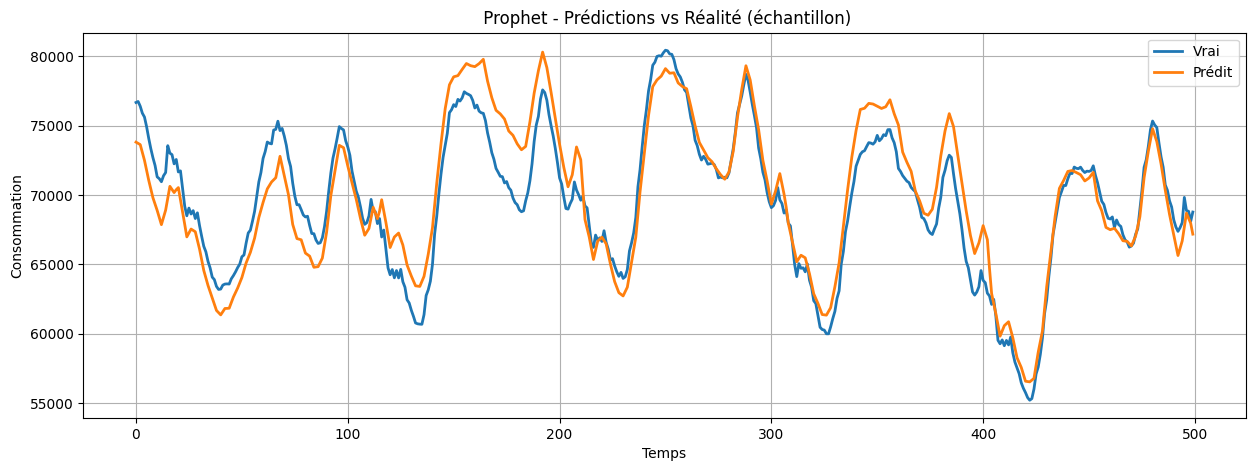

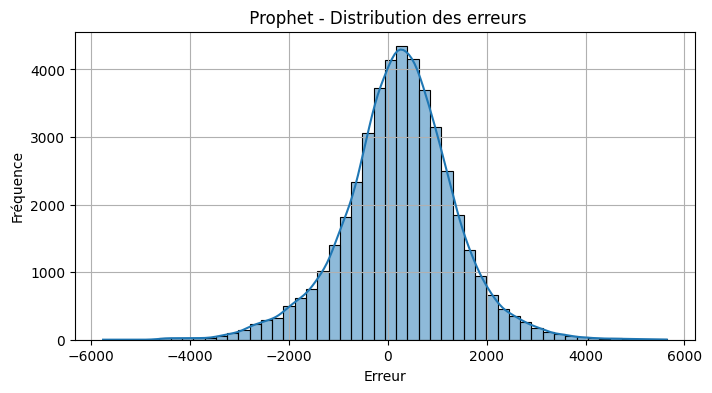

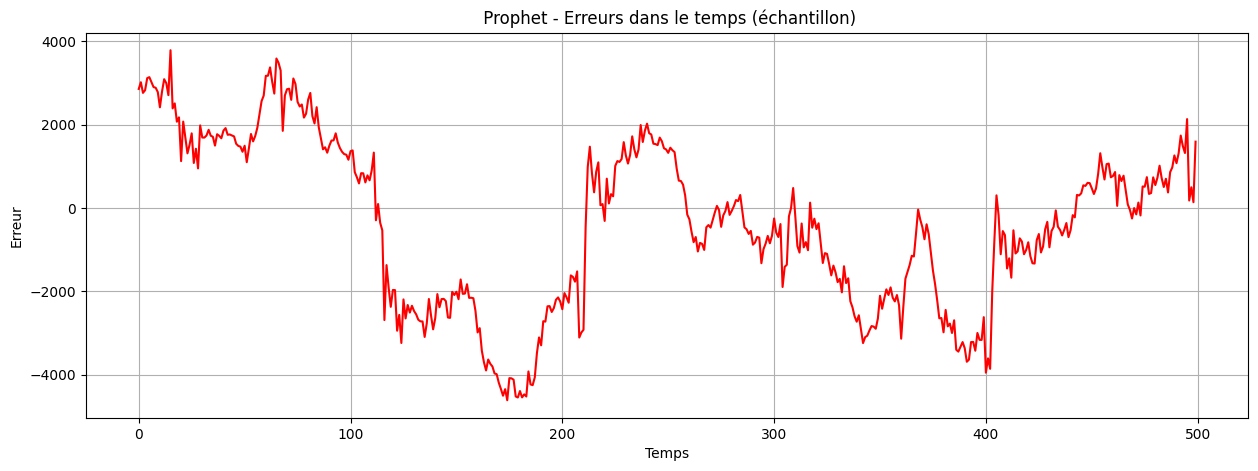

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Créer un dossier pour enregistrer les graphes
os.makedirs("mlruns_artifacts", exist_ok=True)

# === 1. Prédictions vs Réalité ===
plt.figure(figsize=(15, 5))
plt.plot(y_true[:500], label="Vrai", linewidth=2)
plt.plot(y_pred[:500], label="Prédit", linewidth=2)
plt.title(" Prophet - Prédictions vs Réalité (échantillon)")
plt.xlabel("Temps")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plot_path_1 = "mlruns_artifacts/prophet_pred_vs_true.png"
plt.savefig(plot_path_1)
mlflow.log_artifact(plot_path_1)

# === 2. Distribution des erreurs ===
errors = y_true - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(errors, bins=50, kde=True)
plt.title(" Prophet - Distribution des erreurs")
plt.xlabel("Erreur")
plt.ylabel("Fréquence")
plt.grid(True)
plot_path_2 = "mlruns_artifacts/prophet_distribution_erreurs.png"
plt.savefig(plot_path_2)
mlflow.log_artifact(plot_path_2)

# === 3. Évolution des erreurs dans le temps ===
plt.figure(figsize=(15, 5))
plt.plot(errors[:500], color="red")
plt.title(" Prophet - Erreurs dans le temps (échantillon)")
plt.xlabel("Temps")
plt.ylabel("Erreur")
plt.grid(True)
plot_path_3 = "mlruns_artifacts/prophet_erreurs_temps.png"
plt.savefig(plot_path_3)
mlflow.log_artifact(plot_path_3)
